In [62]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from glob import glob
import keras
from keras.preprocessing import image                  
from tqdm import tqdm
import os, os.path
import imageio
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import class_weight

<h1>DATA PREPROCESSING</h1>

In [2]:
os.chdir('C:/Users/mwangit/Desktop/projects/datasetss/dataset')

In [3]:
#project_dir = "/content/gdrive/My Drive/Data Scientist/breast_cancer"
train_path='C:/Users/mwangit/Desktop/projects/datasetss/dataset/train'
test_path='C:/Users/mwangit/Desktop/projects/datasetss/dataset/test'

In [4]:
# project_dir = "."
#data_dir = project_dir + "/data"
#image_source_dir = data_dir + "/originals"

In [5]:
#train data preprocessing
CATEGORIES=["benign","malignant"]
img_size=150
train_data=[]

for cat in CATEGORIES:
    path=os.path.join(train_path,cat)
    label=CATEGORIES.index(cat)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        img_array=cv2.imread(img_path)
        img_array=cv2.resize(img_array , (img_size,img_size))
        #plt.imshow(img_array )
        train_data.append([img_array,label])

In [9]:
#len(train_data)
random.shuffle(train_data)

<h1>CHECKING THE SIZE OF EACH CATEGORY OF THE DATASET</h1>

Benign

In [10]:
len([name for name in os.listdir(train_path + "/benign/") if os.path.isfile(os.path.join(train_path + "/benign/", name))])

9206

Malign

In [11]:
len([name for name in os.listdir(train_path + "/malignant/") if os.path.isfile(os.path.join(train_path + "/malignant/", name))])

12080

<h1>CONVERTING PROCESSED DATA TO NUMPY ARRAY</h1>

In [12]:
#image_dest_dir = data_dir + "/keras"
#saving the data 
X_train=[]
y_train=[]

In [13]:
for features, label in train_data:
    X_train.append(features)
    y_train.append(label)
    
X_train=np.array(X_train) 
y_train=np.array(y_train)

In [15]:
y_train[:100]

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1])

<h1>NORMALIZING DATASET FOR FASTER PROCESSING</h1>

In [16]:
X_train=X_train/255
#X_train

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [23]:
X_train.shape

(21286, 150, 150, 3)

<h1>DEFINING PERFORMANCE METRICS USED TO ANALYSE THE MODEL AND CREATING THE MODEL</h1>

In [25]:
def sensitivity(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
  true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
  return true_negatives / (possible_negatives + K.epsilon())

def fmed(y_true, y_pred):
  spec = specificity(y_true, y_pred)
  sens = sensitivity(y_true, y_pred)
  fmed = 2 * (spec * sens)/(spec+sens+K.epsilon())
  return fmed

def f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

def generate_model(opt=keras.optimizers.Adam()):
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))    
    
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', sensitivity, specificity, fmed, f1])
    return model

<h1>TRAINING MODEL WITH ADAM OPTIMIZER AND SAVING THE BEST WEIGHTS IN H5 FILE </h1>

In [26]:
#num_train_samples = 10000
#num_validation_samples = 1000
batch_size = 32
model = generate_model(opt=keras.optimizers.Adam())
# model.load_weights(data_dir + '/nn_best_model_cv_val_fmed.h5')
history_val_fmed=model.fit(
    X_train,y_train,
    #steps_per_epoch= num_train_samples // batch_size,
    validation_split=0.2,
    #validation_steps= num_validation_samples // batch_size,
    epochs=50, 
    verbose=1,
        callbacks=[
          EarlyStopping(monitor='val_fmed', mode="max", verbose=1, patience=9),
          ModelCheckpoint(train_path + '/nn_best_model_cv_val_fmed.h5', monitor='val_fmed', mode="max", verbose=1, save_best_only=True)
        ],
    )

Epoch 1/50
533/533 [==============================] - ETA: 0s - loss: 0.5691 - accuracy: 0.6851 - sensitivity: 0.8512 - specificity: 0.4707 - fmed: 0.5464 - f1: 0.7503
Epoch 00001: val_fmed improved from -inf to 0.68773, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed.h5
533/533 [==============================] - 497s 932ms/step - loss: 0.5691 - accuracy: 0.6851 - sensitivity: 0.8512 - specificity: 0.4707 - fmed: 0.5464 - f1: 0.7503 - val_loss: 0.4893 - val_accuracy: 0.7640 - val_sensitivity: 0.9057 - val_specificity: 0.5688 - val_fmed: 0.6877 - val_f1: 0.8145
Epoch 2/50
533/533 [==============================] - ETA: 0s - loss: 0.4385 - accuracy: 0.7737 - sensitivity: 0.8909 - specificity: 0.6232 - fmed: 0.7221 - f1: 0.8119
Epoch 00002: val_fmed improved from 0.68773 to 0.76968, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed.h5
533/533 [==============================] - 516s 968ms/

Epoch 15/50
533/533 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.8547 - sensitivity: 0.7793 - specificity: 0.9486 - fmed: 0.8504 - f1: 0.8533
Epoch 00015: val_fmed improved from 0.85939 to 0.86782, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed.h5
533/533 [==============================] - 472s 885ms/step - loss: 0.2631 - accuracy: 0.8547 - sensitivity: 0.7793 - specificity: 0.9486 - fmed: 0.8504 - f1: 0.8533 - val_loss: 0.2517 - val_accuracy: 0.8673 - val_sensitivity: 0.8458 - val_specificity: 0.9014 - val_fmed: 0.8678 - val_f1: 0.8789
Epoch 16/50
533/533 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.8578 - sensitivity: 0.7826 - specificity: 0.9555 - fmed: 0.8561 - f1: 0.8572
Epoch 00016: val_fmed improved from 0.86782 to 0.87595, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed.h5
533/533 [==============================] - 474s 8

533/533 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9238 - sensitivity: 0.8819 - specificity: 0.9792 - fmed: 0.9255 - f1: 0.9267
Epoch 00043: val_fmed improved from 0.93044 to 0.93067, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed.h5
533/533 [==============================] - 473s 887ms/step - loss: 0.1406 - accuracy: 0.9238 - sensitivity: 0.8819 - specificity: 0.9792 - fmed: 0.9255 - f1: 0.9267 - val_loss: 0.1766 - val_accuracy: 0.9277 - val_sensitivity: 0.9061 - val_specificity: 0.9603 - val_fmed: 0.9307 - val_f1: 0.9346
Epoch 44/50
533/533 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9258 - sensitivity: 0.8801 - specificity: 0.9831 - fmed: 0.9267 - f1: 0.9277
Epoch 00044: val_fmed improved from 0.93067 to 0.93288, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed.h5
533/533 [==============================] - 451s 847ms/step - 

<h1>ANALYZING MODEL USING THE PERFORMANCE METRICS BUT FOCUSING ON SPECIFICITY AND SENSITIVITY</h1>

dict_keys(['loss', 'accuracy', 'sensitivity', 'specificity', 'fmed', 'f1', 'val_loss', 'val_accuracy', 'val_sensitivity', 'val_specificity', 'val_fmed', 'val_f1'])


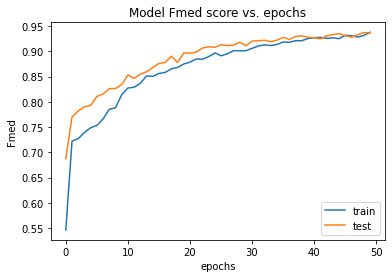

In [27]:
# list all data in history
history = history_val_fmed
print(history.history.keys())

# summarize history for fmed score
plt.plot(history.history['fmed'])
plt.plot(history.history['val_fmed'])
plt.title('Model Fmed score vs. epochs')
plt.ylabel('Fmed')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

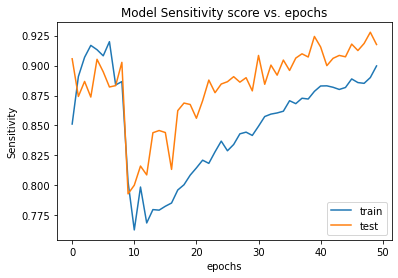

In [28]:
# summarize history for sensitivity score
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model Sensitivity score vs. epochs')
plt.ylabel('Sensitivity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



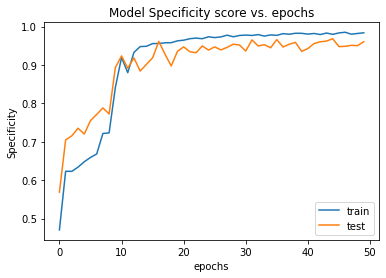

In [29]:
# summarize history for specificity score
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model Specificity score vs. epochs')
plt.ylabel('Specificity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



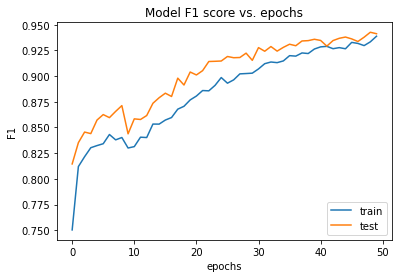

In [30]:
# summarize history for f1 score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 score vs. epochs')
plt.ylabel('F1')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



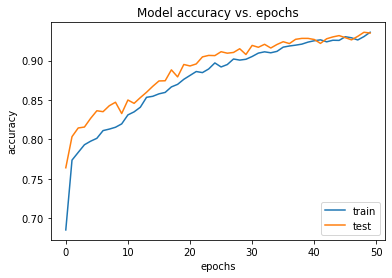

In [34]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



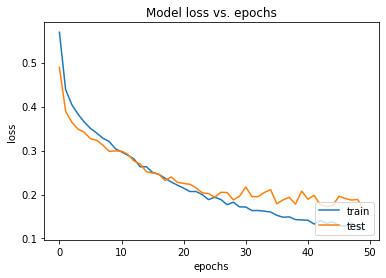

In [35]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

<h1>PREDICTING ON THE TEST DATA WITH MODEL WITH THE BEST WEIGHTS</h1>

In [40]:
test_gen=ImageDataGenerator()

In [41]:
test_generator = test_gen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        batch_size=32,
        color_mode="rgb",
        class_mode='binary',
        shuffle=False,
        
)

Found 3290 images belonging to 2 classes.


In [42]:
model = generate_model()

<h2>LOADING THE BEST WEIGHTS</h2>

In [43]:
model.load_weights(train_path + '/nn_best_model_cv_val_fmed.h5')

In [45]:
probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

<h1>CONFUSION MATRIX SHOWING RESULTS OF THE PREDICTIONS</h1>

In [46]:
confusion_matrix(y_true, y_pred)

array([[1594,   66],
       [ 169, 1461]], dtype=int64)

In [47]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

<h1>PERCENTAGE OF SPECIFICITY AND SENSITIVITY</h1>

In [48]:
specificity = tn / (tn+fp)
specificity

0.9602409638554217

In [57]:
sensitivity = tp / (tp + fn)
sensitivity

0.896319018404908

<h1>TRAINING NEW MODEL WITH SDG OPTIMISER FOR COMPARISON WITH MODEL USING ADAM </h1>

In [64]:
def sensitivity(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
  true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
  possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
  return true_negatives / (possible_negatives + K.epsilon())

def fmed(y_true, y_pred):
  spec = specificity(y_true, y_pred)
  sens = sensitivity(y_true, y_pred)
  fmed = 2 * (spec * sens)/(spec+sens+K.epsilon())
  return fmed

def f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

def generate_model(opt = tf.keras.optimizers.SGD(learning_rate=0.01, nesterov=True)):
    
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))    
    
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', sensitivity, specificity, fmed, f1])
    return model

In [65]:
batch_size = 32

model = generate_model(opt)
# model.load_weights(data_dir + '/nn_best_model_cv_val_fmed.h5')
history_val_fmed_sgd = model.fit(
    X_train,y_train,
    validation_split=0.2,
    epochs=50,
    verbose=1,
        callbacks=[
          EarlyStopping(monitor='val_fmed', mode="max", verbose=1, patience=9),
          ModelCheckpoint(train_path + '/nn_best_model_cv_val_fmed_sgd.h5', monitor='val_fmed', mode="max", verbose=1, save_best_only=True)
        ],
    )

Epoch 1/50
533/533 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.5630 - sensitivity: 0.9684 - specificity: 0.0370 - fmed: 0.0576 - f1: 0.7093
Epoch 00001: val_fmed improved from -inf to 0.00000, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed_sgd.h5
533/533 [==============================] - 464s 870ms/step - loss: 0.6842 - accuracy: 0.5630 - sensitivity: 0.9684 - specificity: 0.0370 - fmed: 0.0576 - f1: 0.7093 - val_loss: 0.6726 - val_accuracy: 0.5803 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_fmed: 0.0000e+00 - val_f1: 0.7303
Epoch 2/50
533/533 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.5918 - sensitivity: 0.9018 - specificity: 0.1902 - fmed: 0.2885 - f1: 0.7090
Epoch 00002: val_fmed improved from 0.00000 to 0.08237, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed_sgd.h5
533/533 [=============================

Epoch 29/50
533/533 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.8437 - sensitivity: 0.8765 - specificity: 0.8027 - fmed: 0.8321 - f1: 0.8602
Epoch 00029: val_fmed improved from 0.83130 to 0.83517, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed_sgd.h5
533/533 [==============================] - 457s 858ms/step - loss: 0.2956 - accuracy: 0.8437 - sensitivity: 0.8765 - specificity: 0.8027 - fmed: 0.8321 - f1: 0.8602 - val_loss: 0.3023 - val_accuracy: 0.8481 - val_sensitivity: 0.8866 - val_specificity: 0.8003 - val_fmed: 0.8352 - val_f1: 0.8698
Epoch 30/50
533/533 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8443 - sensitivity: 0.8754 - specificity: 0.8040 - fmed: 0.8320 - f1: 0.8607
Epoch 00030: val_fmed improved from 0.83517 to 0.83681, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed_sgd.h5
533/533 [==============================] 

Epoch 44/50
533/533 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.8782 - sensitivity: 0.8486 - specificity: 0.9150 - fmed: 0.8760 - f1: 0.8831
Epoch 00044: val_fmed improved from 0.86874 to 0.87741, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed_sgd.h5
533/533 [==============================] - 437s 820ms/step - loss: 0.2352 - accuracy: 0.8782 - sensitivity: 0.8486 - specificity: 0.9150 - fmed: 0.8760 - f1: 0.8831 - val_loss: 0.2474 - val_accuracy: 0.8828 - val_sensitivity: 0.8979 - val_specificity: 0.8657 - val_fmed: 0.8774 - val_f1: 0.8965
Epoch 45/50
533/533 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.8801 - sensitivity: 0.8500 - specificity: 0.9184 - fmed: 0.8783 - f1: 0.8858
Epoch 00045: val_fmed improved from 0.87741 to 0.87839, saving model to C:/Users/mwangit/Desktop/projects/datasetss/dataset/train\nn_best_model_cv_val_fmed_sgd.h5
533/533 [==============================] 

<h1>ANALYZING  MODEL PERFORMANCE</h1>

In [ ]:
history = history_val_fmed_sgd
#print(history.history.keys())

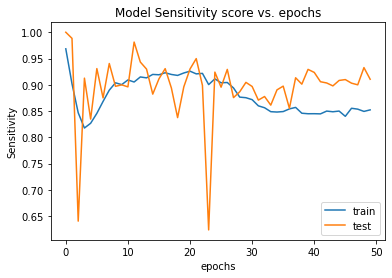

In [67]:
# summarize history for sensitivity score
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Model Sensitivity score vs. epochs')
plt.ylabel('Sensitivity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



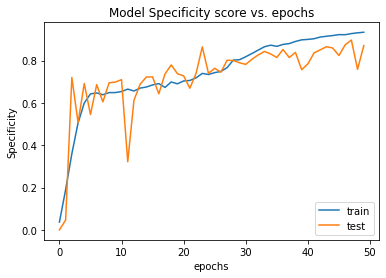

In [68]:
# summarize history for specificity score
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Model Specificity score vs. epochs')
plt.ylabel('Specificity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



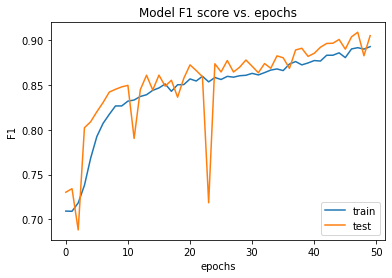

In [69]:
# summarize history for f1 score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 score vs. epochs')
plt.ylabel('F1')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



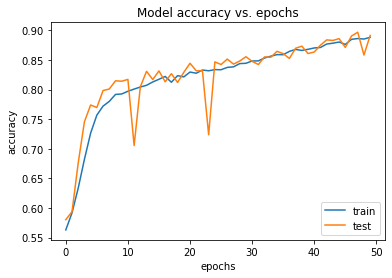

In [72]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



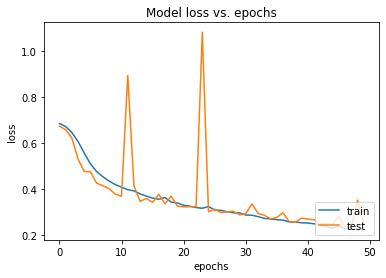

In [73]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [74]:
test_gen=ImageDataGenerator()

In [75]:
test_generator = test_gen.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        batch_size=32,
        color_mode="rgb",
        class_mode='binary',
        shuffle=False,
        
)

Found 3290 images belonging to 2 classes.


<h1>LOADING BEST WEIGHT TO MODEL FOR PREDICTION</h1>

In [76]:
model = generate_model(opt=keras.optimizers.SGD(lr=0.01, nesterov=True))

In [114]:
model.load_weights(train_path + '/nn_best_model_cv_val_fmed_sgd.h5')

In [117]:
model.save('3-conv-3-dense-64-featDet-CNN.h5')

<h1>EXPLICITLY DEFINING THE PERFORMANCE METRICS USED BECAUSE THE MODEL WAS LOADED FROM THE LOCAL MACHINE</h1>

In [131]:
#model=tf.keras.models.load_model('C:/Users/mwangit/Desktop/projects/datasetss/dataset/3-conv-3-dense-64-featDet-CNN.keras')
direc= 'C:/Users/mwangit/Desktop/projects/datasetss/dataset/3-conv-3-dense-64-featDet-CNN.h5'
dependancies={
    'sensitivity':sensitivity,
    'specificity':specificity,
    'fmed':fmed,
    'f1':f1
}
model=tf.keras.models.load_model(
    direc, custom_objects=dependancies, compile=True, options=None
)

In [132]:
probabilities = model.predict(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5

<h2>CONFUSION MATRIX SHOWING RESULTS OF PREDICTIONS</h2>

In [133]:
confusion_matrix(y_true, y_pred)

array([[1650,   10],
       [   5, 1625]], dtype=int64)

In [136]:
test_generator.class_indices

{'benign': 0, 'malignant': 1}

<h2>% OF SPECIFICITY AND SENSITIVITY</h2>

In [81]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [82]:
specificity = tn / (tn+fp)
specificity

0.9939759036144579

In [83]:
sensitivity = tp / (tp + fn)
sensitivity

0.9969325153374233

In [89]:
np.round(probabilities)

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

<h1>BETTER VISUALIZATION OF THE CONFUSION MATRIX</h1>

In [108]:
cm=confusion_matrix(y_true=test_generator.classes,y_pred=probabilities > 0.5)

In [109]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1650   10]
 [   5 1625]]


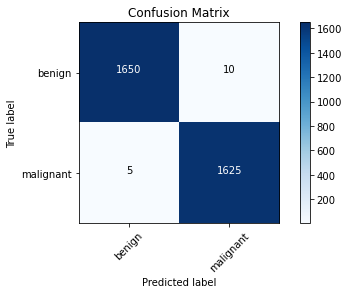

In [110]:
cm_plot_labels=['benign','malignant']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

<h1>The model using SDG optimizer performed better the model using Adam optimizer having a better specificity and sensitivity percentage and predicting the test data more accurately</h1>